# Testing a first-person shooter (FPS) game 

Ideally, we want to test Quake, but here we test with a pre-built RL FPS for a proof of concept that we can train an FPS game with RLLib with a gymnasium style wrapper.

https://github.com/Farama-Foundation/ViZDoom

- git clone the scenarios folder from the ViZDoom repo
- create a conda environment with the .yml
    - conda env create -f rl-project.yml


Next steps:
 - Research strengths and weaknesses of each model application (Tiana)
 - Attempt a similar game to Quake (Allen)


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces

from vizdoom import DoomGame

import ray
from ray.tune.registry import register_env
from ray.rllib.algorithms.dqn import DQNConfig



In [2]:

# Path to the ViZDoom basic scenario config.
SCENARIO_PATH = os.path.abspath(os.path.join("scenarios", "basic.cfg"))
print("SCENARIO_PATH:", SCENARIO_PATH, "exists:", os.path.exists(SCENARIO_PATH))


# Observation resolution
RES_W, RES_H = 84, 84

# Steps per action (frame skip) and max episode length
FRAME_SKIP = 4
MAX_EPISODE_STEPS = 200

SCENARIO_PATH: /Users/tianale/Documents/DSANReinforcementLearning/RL_final_project/scenarios/basic.cfg exists: True


In [3]:
class VizDoomBasicEnv(gym.Env):
    """
    Quake-like FPS RL environment on top of ViZDoom 'basic' scenario.

    Observation: 84x84 grayscale image (last frame)
    Action space (Discrete):
      0: no-op
      1: move left
      2: move right
      3: shoot
      4: move forward + shoot   (you can customize later)

    Reward shaping modes (config['reward_mode']):
      - 'sparse':      reward = raw ViZDoom reward
      - 'time_penalty':reward = raw - 0.01 per step
      - 'dense':       reward = raw - 0.01 per step
                       +5  if raw_reward > 0 (hit/kill)
                       -0.1 if we shoot but get no positive reward
    """

    metadata = {"render_modes": ["human", "rgb_array"]}

    def __init__(self, config=None, render_mode=None):
        super().__init__()
        self.render_mode = render_mode

        # config can come from RLlib env_config
        config = config or {}
        self.reward_mode = config.get("reward_mode", "sparse")

        # Initialize ViZDoom game
        self.game = DoomGame()
        if not os.path.exists(SCENARIO_PATH):
            raise FileNotFoundError(
                f"Could not find {SCENARIO_PATH}. "
                "Make sure the 'scenarios' folder with 'basic.cfg' "
                "is next to this notebook, or update SCENARIO_PATH."
            )

        self.game.load_config(SCENARIO_PATH)
        self.game.init()

        # The 'basic' scenario usually uses 3 buttons:
        # MOVE_LEFT, MOVE_RIGHT, ATTACK
        # We define a small discrete set of combinations:
        self.actions = [
            [0, 0, 0],  # 0: no-op
            [1, 0, 0],  # 1: move left
            [0, 1, 0],  # 2: move right
            [0, 0, 1],  # 3: shoot
            [0, 0, 1],  # 4: also shoot; customize to forward+shoot if desired
        ]
        self.action_space = spaces.Discrete(len(self.actions))

        # Observation: 84x84 grayscale image, 0-255
        self.observation_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(RES_H, RES_W, 1),
            dtype=np.float32,
        )

        self.step_count = 0

    # helper: get processed observation
    def _get_obs(self):
        state = self.game.get_state()
        if state is None:
            # Episode might be finished this step
            return np.zeros(self.observation_space.shape, dtype=np.float32)

        screen = state.screen_buffer  # (C, H, W)
        screen = np.transpose(screen, (1, 2, 0))  # (H, W, C)

        # Grayscale
        gray = cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)

        # Resize to (RES_W, RES_H)
        gray_resized = cv2.resize(gray, (RES_W, RES_H), interpolation=cv2.INTER_AREA)

        # Normalize to [0, 1] and add channel dim
        obs = gray_resized.astype(np.float32) / 255.0  # (H, W)
        obs = np.expand_dims(obs, axis=-1)             # (H, W, 1)

        return obs


    # helper: reward shaping
    def _shape_reward(self, raw_reward: float, action: int) -> float:
        """
        Apply different reward shaping schemes to the raw ViZDoom reward.
        """
        mode = self.reward_mode

        if mode == "sparse":
            # Just use what the scenario gives (e.g., big + for kill)
            return raw_reward

        if mode == "time_penalty":
            # Encourage the agent to solve the task quickly
            return raw_reward - 0.01

        if mode == "dense":
            # Start with time penalty
            reward = raw_reward - 0.01

            # If we got some positive raw reward, boost it (e.g., hit/kill)
            if raw_reward > 0:
                reward += 5.0

            # If we chose a shooting action but did not get positive reward,
            # lightly penalize "wasted" shots to encourage aiming.
            if action in [3, 4] and raw_reward <= 0:
                reward -= 0.1

            return reward

        # Fallback if mode is unknown
        return raw_reward

    # Gymnasium API
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.game.new_episode()
        self.step_count = 0
        obs = self._get_obs()
        return obs, {}

    def step(self, action):
        self.step_count += 1

        doom_action = self.actions[int(action)]

        # Execute the action for FRAME_SKIP tics; ViZDoom returns a raw reward
        raw_reward = self.game.make_action(doom_action, FRAME_SKIP)

        # Apply our shaping
        reward = self._shape_reward(raw_reward, action)

        terminated = self.game.is_episode_finished()
        truncated = False

        if self.step_count >= MAX_EPISODE_STEPS:
            truncated = True
            terminated = True

        if terminated:
            obs = np.zeros(self.observation_space.shape, dtype=np.float32)
        else:
            obs = self._get_obs()

        info = {
            "raw_reward": raw_reward,
            "reward_mode": self.reward_mode,
        }
        return obs, reward, terminated, truncated, info

    def render(self):
        # For GUI, configure window visibility in the .cfg file
        pass

    def close(self):
        self.game.close()


In [4]:
env = VizDoomBasicEnv(config={"reward_mode": "dense"})
obs, info = env.reset()
print(obs.shape, obs.dtype, obs.min(), obs.max())
env.close()


(84, 84, 1) float32 0.003921569 0.6039216


In [5]:
# Test with different reward shaping modes: 'sparse', 'time_penalty', 'dense'
env = VizDoomBasicEnv(config={"reward_mode": "dense"})

for ep in range(3):
    obs, info = env.reset()
    done = False
    total_reward = 0.0
    total_raw_reward = 0.0
    steps = 0

    while not done:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        total_raw_reward += info.get("raw_reward", 0.0)
        steps += 1

    print(
        f"Episode {ep+1}: shaped_total={total_reward:.2f}, "
        f"raw_total={total_raw_reward:.2f}, steps={steps}"
    )

env.close()


Episode 1: shaped_total=-389.35, raw_total=-385.00, steps=75
Episode 2: shaped_total=-25.65, raw_total=-29.00, steps=25
Episode 3: shaped_total=-383.85, raw_total=-380.00, steps=75


In [6]:
ray.shutdown()
ray.init(ignore_reinit_error=True)

def env_creator(env_config):
    # env_config comes from RLlib; we pass it into our Env so it can read reward_mode
    return VizDoomBasicEnv(config=env_config)

register_env("VizDoomBasic-v0", env_creator)

# Choose which reward shaping scheme to train with here:
reward_mode = "dense"   # 'sparse', 'time_penalty', or 'dense'

dqn_config = (
    DQNConfig()
    .environment(
        env="VizDoomBasic-v0",
        env_config={"reward_mode": reward_mode},
    )
    .framework("torch")
    # NEW API: use env_runners instead of rollouts
    .env_runners(
        num_env_runners=2,        # like num_rollout_workers
        # num_envs_per_env_runner=1,  # defaults to 1, can leave out
    )
    .resources(num_gpus=0)        # set to 1 if you want GPU
    .training(
        gamma=0.99,
        lr=1e-4,
        train_batch_size=64,
    )
)



algo = dqn_config.build()


2025-11-22 16:27:04,550	INFO worker.py:2023 -- Started a local Ray instance.
/opt/anaconda3/envs/rl-project/lib/python3.10/site-packages/ray/_private/worker.py:2062: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
2025-11-22 16:27:05,231	WARNING 2096020887.py:35 -- DeprecationWarning: `build` has been deprecated. Use `AlgorithmConfig.build_algo` instead. This will raise an error in the future!
2025-11-22 16:27:05,233	WARNING algorithm_config.py:5058 -- You are running DQN on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-a

In [7]:
results = []
num_iterations = 10  # adjust based on time/compute

for i in range(num_iterations):
    result = algo.train()
    results.append(result)

    # Newer RLlib often stores these under result["env_runners"]
    env_metrics = result.get("env_runners", {})

    mean_reward = (
        result.get("episode_reward_mean")
        or env_metrics.get("episode_return_mean")
    )
    mean_len = (
        result.get("episode_len_mean")
        or env_metrics.get("episode_len_mean")
    )

    print(
        f"[{reward_mode}][Iter {i+1:03d}] "
        f"mean_reward = {mean_reward} "
        f"mean_len = {mean_len}"
    )


checkpoint_path = algo.save()
print("Checkpoint saved at:", checkpoint_path)


[dense][Iter 001] mean_reward = -177.55799999999996 mean_len = 47.3


(pid=gcs_server) [2025-11-22 16:27:33,966 E 65050 59747149] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-11-22 16:27:34,500 E 65054 59747270] (raylet) main.cc:979: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(SingleAgentEnvRunner pid=65066) [2025-11-22 16:27:35,101 E 65066 59747576] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-11-22 16:27:35,242 E 65044 59747320] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent

[dense][Iter 002] mean_reward = -175.19738095238094 mean_len = 47.11904761904762
[dense][Iter 003] mean_reward = -133.86539999999997 mean_len = 40.94
[dense][Iter 004] mean_reward = -102.67439999999999 mean_len = 37.24
[dense][Iter 005] mean_reward = -131.55259999999998 mean_len = 41.66
[dense][Iter 006] mean_reward = -152.05919999999995 mean_len = 44.52
[dense][Iter 007] mean_reward = -216.5055999999999 mean_len = 55.36
[dense][Iter 008] mean_reward = -171.16939999999994 mean_len = 49.94
[dense][Iter 009] mean_reward = -175.7893999999999 mean_len = 50.94
[dense][Iter 010] mean_reward = -188.9841999999999 mean_len = 53.42
Checkpoint saved at: TrainingResult(checkpoint=Checkpoint(filesystem=local, path=/var/folders/qz/17n0v3wd01q52t9r84rcvtzc0000gn/T/tmp9wba35am), metrics={'timers': {'training_iteration': 36.737307033536325, 'restore_env_runners': 0.00010027491757456114, 'training_step': 0.37206992687443796, 'env_runner_sampling_timer': 0.051261721090583356, 'replay_buffer_add_data_time

In [8]:
result = algo.train()
print(result.keys())
print(result.get("env_runners", {}))


dict_keys(['timers', 'env_runners', 'num_training_step_calls_per_iteration', 'replay_buffer', 'learners', 'num_env_steps_sampled_lifetime', 'fault_tolerance', 'env_runner_group', 'done', 'training_iteration', 'trial_id', 'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip', 'config', 'time_since_restore', 'iterations_since_restore', 'perf'])
{'env_to_module_connector': {'timers': {'connectors': {'add_states_from_episodes_to_batch': np.float64(1.5540578592746303e-06), 'add_time_dim_to_batch_and_zero_pad': np.float64(3.851875232552605e-06), 'batch_individual_items': np.float64(2.0979938911251898e-05), 'numpy_to_tensor': np.float64(4.884220006448512e-05), 'add_observations_from_episodes_to_batch': np.float64(1.1838691937974746e-05)}}, 'connector_pipeline_timer': np.float64(0.00013710251514315722)}, 'num_agent_steps_sampled': {'default_agent': 1000.0}, 'module_to_env_connector': {'timers': {'connectors': {'un_batch_to_individual_items': np.float64(1.1356962

In [9]:
def extract_mean_reward(result):
    """Return the mean episode reward for a single RLlib result dict."""
    # New RLlib puts metrics under result["env_runners"]
    env_metrics = result.get("env_runners", {})

    return (
        result.get("episode_reward_mean")           # old RLlib API
        or env_metrics.get("episode_return_mean")   # new API
        or env_metrics.get("episode_reward_mean")   # occasionally appears
    )


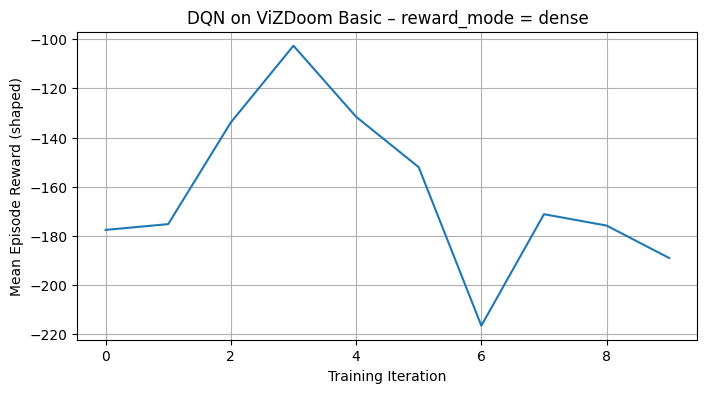

In [10]:
episode_rewards = [extract_mean_reward(r) for r in results]

plt.figure(figsize=(8, 4))
plt.plot(episode_rewards)
plt.xlabel("Training Iteration")
plt.ylabel("Mean Episode Reward (shaped)")
plt.title(f"DQN on ViZDoom Basic – reward_mode = {reward_mode}")
plt.grid(True)
plt.show()


If we use this model, we need to experiment with more iterations (at least 100). From the graph above, it looks like the model is not done training yet.